Read raw binary data from com port all at once


Required: pip install pyserial, wave

In [1]:
import serial
import numpy as np
frequency = 16000

def listen_on_com_port(com_port, baud_rate, seconds):
    serial_com = serial.Serial(port=com_port, baudrate=baud_rate)
    data_list = np.zeros(frequency * seconds)
    
    data = serial_com.read(size = len(data_list) * 2)
    data_list = np.frombuffer(data, np.int16)

    return data_list


In [34]:
com_port = "COM4"
baud_rate = 9600
data_list = listen_on_com_port(com_port, baud_rate, seconds=60)

Plot the raw data as a sound signal

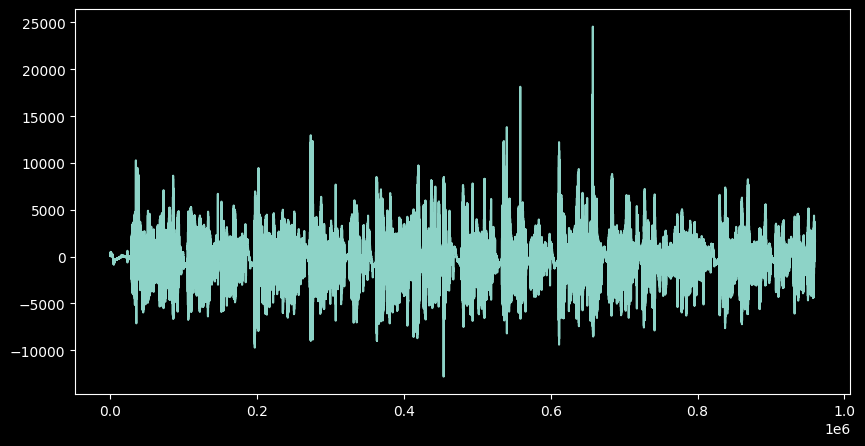

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(data_list)
plt.show()

Save the raw data into a wav audio file

In [5]:
import wave

def save_data_list_as_wav(data_list, file_name):
    with wave.open(file_name, "wb") as wav_file:
        wav_file.setnchannels(1)
        wav_file.setsampwidth(2)
        wav_file.setframerate(frequency)
        wav_file.setnframes(len(data_list))
        
         # Convert the raw data to a byte array
        raw_bytes = data_list.astype(np.int16).tobytes()

        # Write the raw data to the wave file
        wav_file.writeframes(raw_bytes)
       


In [35]:

file_name = "rec/rec_ita_05_elena.wav"
save_data_list_as_wav(data_list, file_name)

Quantize raw values before converting it to an audio file

In [6]:
def quantize_timeseries(data_list):
	scale = int(np.max(data_list)) - int(np.min(data_list))
	print(scale)


	data_quantized = np.add(data_list, - int((np.max(data_list)) + int(np.min(data_list))) / 2)
	data_quantized = np.multiply(data_quantized, 256 / scale).astype("int8")

	data_quantized = data_quantized.astype("int16")
	#data_quantized = np.multiply(data_quantized, 50)
	return data_quantized


In [ ]:

data_quantized = quantize_timeseries(data_list=data_list)
plt.figure(figsize=(10, 5))
plt.plot(data_quantized)
plt.show()

In [113]:

file_name = "sample_test4_quantized.wav"
save_data_list_as_wav(data_quantized, file_name)

Compute log mel spectrogram of the audio sample

Required: pip install librosa

In [47]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os


def spectrogram(audio_file):
	# Load the WAV file
	waveform, sample_rate = librosa.load(audio_file, sr=None)
	print(sample_rate, waveform.shape)

	# Compute the mel spectrogram
	n_fft = 2048  # FFT window size
	hop_length = 512  # Hop length for spectrogram frames
	n_mels = 128  # Number of mel bands

	mel_spec = librosa.feature.melspectrogram(y = waveform, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=4096)
	log_mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.max)
	print(log_mel_spec.shape)

	# Display the log mel spectrogram
	librosa.display.specshow(log_mel_spec, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel', fmax=4096)
	plt.colorbar(format='%+2.0f dB')
	plt.title('Log Mel Spectrogram')
	plt.show()

	return log_mel_spec


16000 (320000,)
(128, 626)


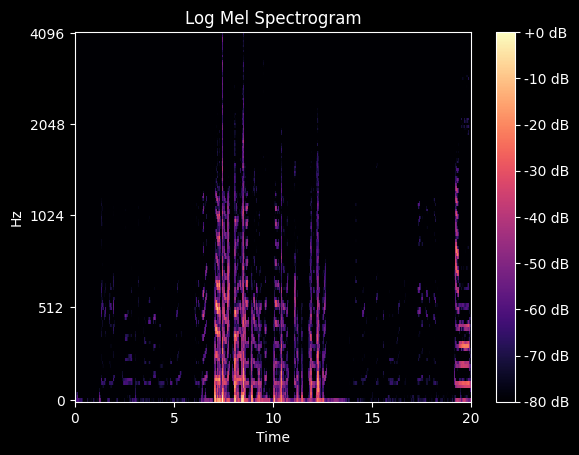

In [114]:

audio_file = os.getcwd() + "\sample_test4.wav"
spectrogram_base = spectrogram(audio_file=audio_file)

16000 (320000,)
(128, 626)


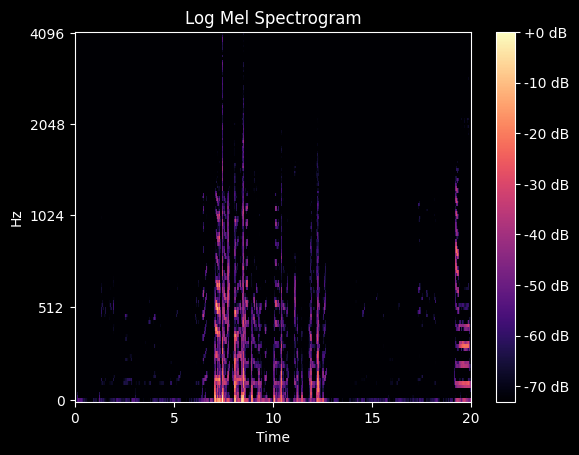

In [115]:

audio_file = os.getcwd() + "\sample_test4_quantized.wav"
quantized_spectrogram = spectrogram(audio_file=audio_file)

Rescaling the audio data to fit within 1 byte (8 bits) instead of the original 2-byte (16-bit) representation, effectively reduces the dynamic range and precision of the audio samples. This reduction in precision can result in a loss of fine details and a lower signal-to-noise ratio in the rescaled log mel spectrogram.

Additionally, quantization introduces quantization noise, which is the error or discrepancy between the original floating-point values and the quantized integer values. This quantization noise can affect the accuracy and fidelity of the rescaled log mel spectrogram.

Plot the quantized version

In [91]:
quantized = np.multiply(np.add(quantized_spectrogram, 40), 256/70).astype("int8")
print(np.min(quantized), np.max(quantized))

-118 125


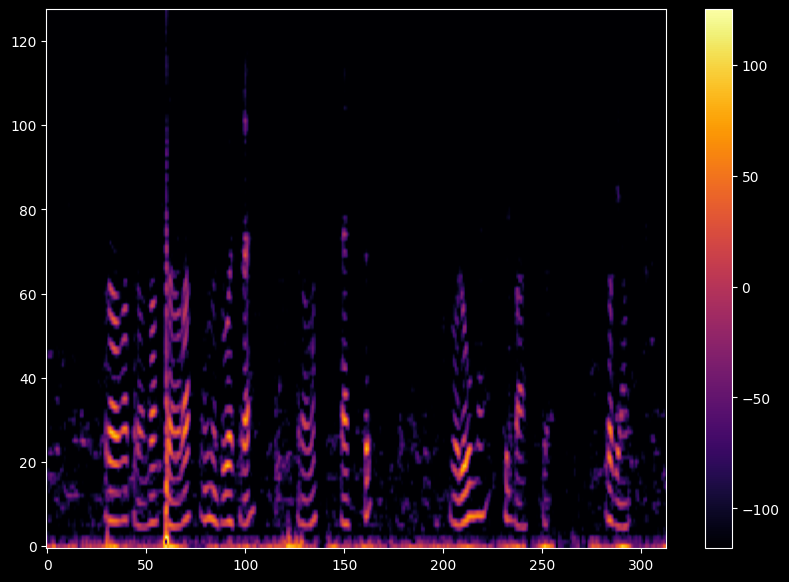

In [92]:
plt.figure(figsize=(10, 7))
plt.imshow(quantized, cmap="inferno", aspect='auto', origin='lower')
plt.colorbar()
plt.show()

## Post - processing time series for 1 byte quantization

Sliding hopping window to apply dynamic range scaling for clearer audio recordings

parameters: _wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=320000, comptype='NONE', compname='not compressed')


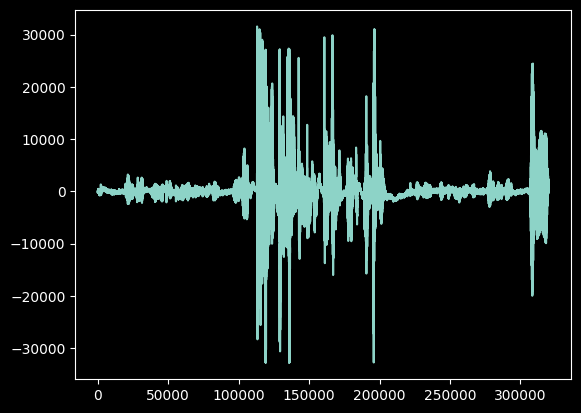

In [1]:
# load audio samples as array of int16
import wave
import os
import matplotlib.pyplot as plt
import numpy as np

wav_rb = wave.open(os.getcwd() + "\sample_test4.wav",'rb')
print ( "parameters:", wav_rb.getparams())
samples = wav_rb.getnframes()
data_rb = wav_rb.readframes(samples)
data_rb = np.frombuffer(data_rb, np.int16)

plt.plot(data_rb)
wav_rb.close()

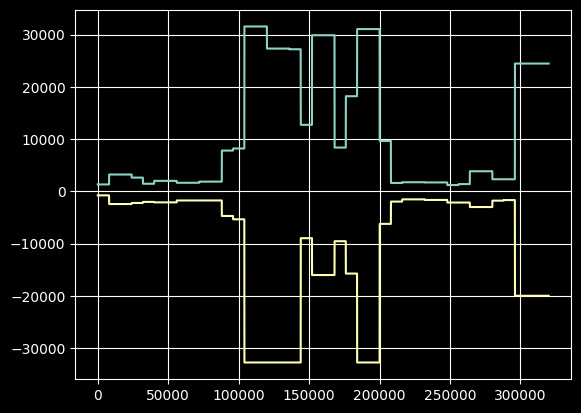

In [27]:
signal = data_rb
max_signal = np.zeros(len(signal))
min_signal = np.zeros(len(signal))
window = 16000
for i in range(0, len(signal) - window, int(window/2)):
    max_signal[i] = np.max(signal[i:i+window])
    min_signal[i] = np.min(signal[i:i+window])
for i in range(1, len(signal)):
    if (max_signal[i] == 0):
        max_signal[i] = max_signal[i-1]
    if (min_signal[i] == 0):
        min_signal[i] = min_signal[i-1]
plt.plot(max_signal)
plt.plot(min_signal)
plt.grid()
plt.show()

63260.0


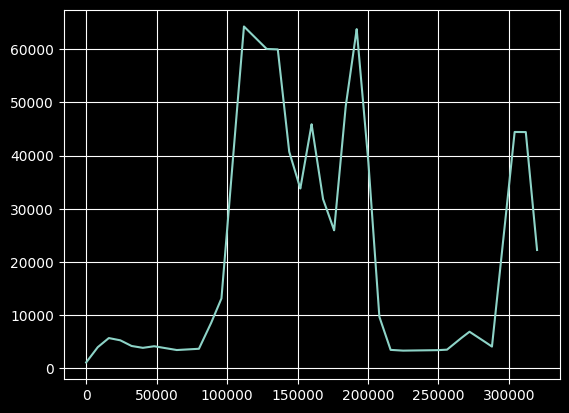

In [41]:
window = 16000
running_average = np.subtract(max_signal, min_signal)
running_average = np.convolve(running_average, np.ones(window)/window, mode='same')

scale = np.max(running_average) - np.min(running_average)
print(scale)


step_factor = np.zeros(len(running_average))
for i in range(len(running_average)):
	if (running_average[i] >= 3/4 * scale):
		step_factor[i] = 1
	elif (running_average[i] >= 1/2 * scale):
		step_factor[i] = 3
	elif (running_average[i] >= 1/4 * scale):
		step_factor[i] = 5
	else:
		step_factor[i] = 8

plt.plot(running_average)
plt.grid()
plt.show()


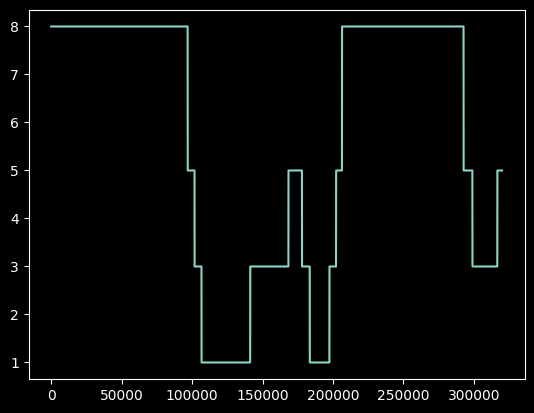

In [42]:
plt.plot(step_factor)
plt.show()

64308


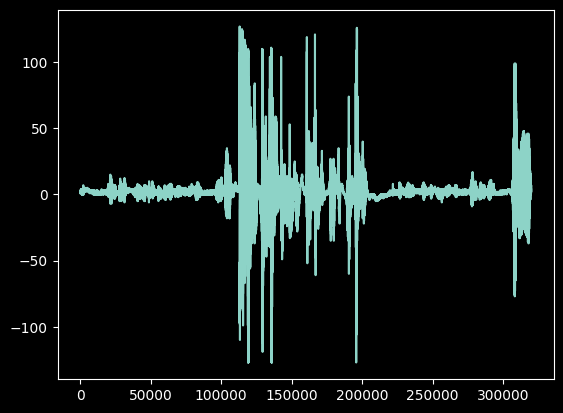

In [43]:
quantized_data_rb = quantize_timeseries(data_rb)
plt.plot(quantized_data_rb)
plt.show()

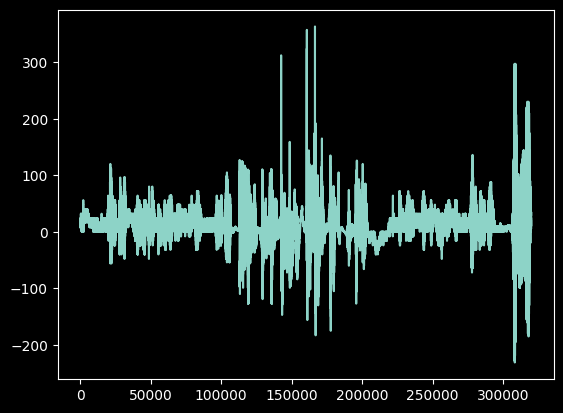

In [44]:
quantized_data_rb = np.multiply(quantized_data_rb, step_factor)
plt.plot(quantized_data_rb)
plt.show()

In [45]:
quantized_data_rb = np.multiply(quantized_data_rb, 10)
save_data_list_as_wav(quantized_data_rb, "post_process_test1.wav")


16000 (320000,)
(128, 626)


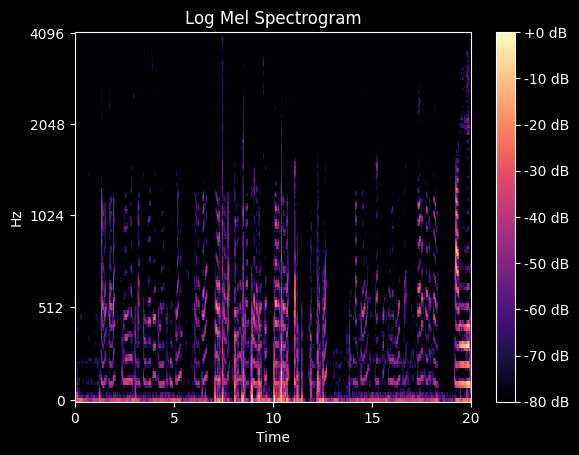

array([[-34.65572 , -27.851002, -32.63214 , ..., -28.09182 , -21.24935 ,
        -25.734356],
       [-56.454315, -62.708138, -56.168945, ..., -63.707474, -63.77536 ,
        -50.581177],
       [-56.49888 , -60.03734 , -61.688553, ..., -68.76825 , -52.723755,
        -50.56698 ],
       ...,
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ]], dtype=float32)

In [48]:
audio_file = os.getcwd() + "\post_process_test1.wav"
spectrogram(audio_file=audio_file)